# Grain sizes counting and distribution testing

## Preparations

In [286]:
import numpy as np
import matplotlib.pyplot as plt
# import ipympl
import imageio.v3 as iio
import skimage

In [287]:
metadata = iio.immeta(uri="data/structure01.jpg")
metadata

{'jfif': 257,
 'jfif_version': (1, 1),
 'dpi': (96, 96),
 'jfif_unit': 1,
 'jfif_density': (96, 96),
 'mode': 'RGB',
 'shape': (355, 267)}

(267, 355)

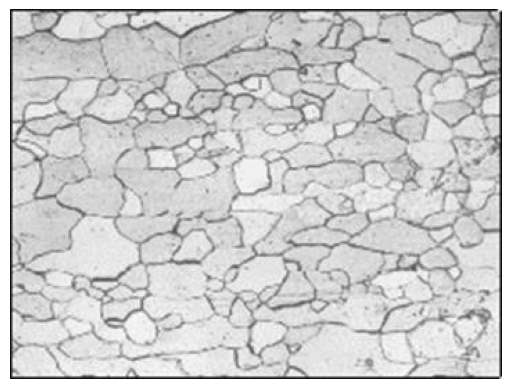

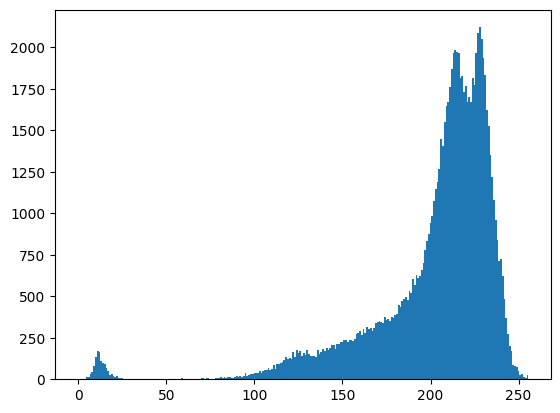

In [288]:
from skimage.filters import gaussian, median, roberts, sobel, scharr, prewitt, difference_of_gaussians, laplace
from skimage.feature import canny
from scipy import ndimage as ndi

image_original = iio.imread(uri="data/structure01.jpg")
fig, ax = plt.subplots()
plt.axis('off')
plt.imshow(image_original)
# print(image_original)
# image_original.shape

bins = np.arange(-0.5, 255+1,1)
fig, ax = plt.subplots()
plt.hist(image_original[:,:,0].flatten(), bins=bins)

image.shape

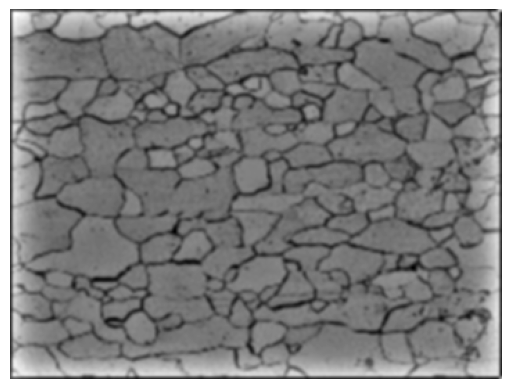

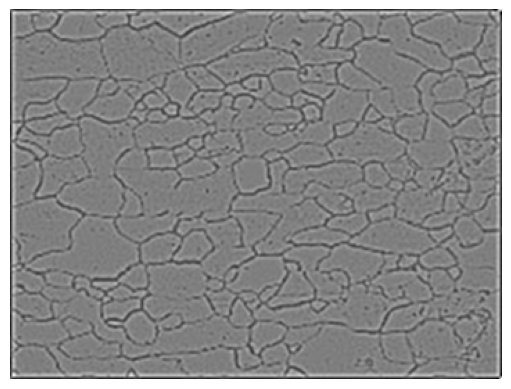

In [289]:
gray_image = skimage.color.rgb2gray(image_original)
# fig, ax = plt.subplots()
# plt.axis('off')
# plt.imshow(gray_image, cmap='gray')
filtered_image = difference_of_gaussians(gray_image, 1, 12)
fig, ax = plt.subplots()
plt.axis('off')
plt.imshow(filtered_image, cmap='gray')
image_edges = laplace(filtered_image, 8)
image = image_edges.copy()
fig, ax = plt.subplots()
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.autoscale(tight=True)
plt.show()

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255 255 255]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [255 255 255]]

 [[255 255 255]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [255 255 255]]

 [[255 255 255]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [  0   0   0]
  [  0   0   0]]]


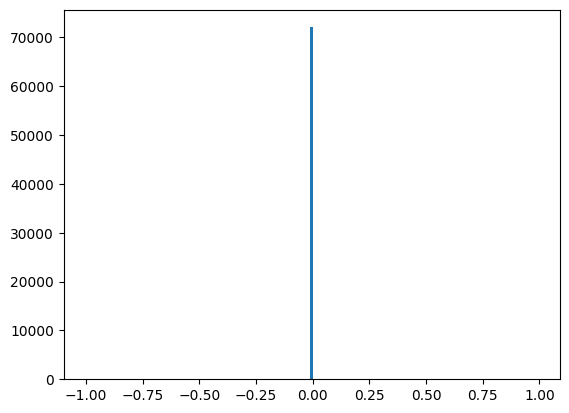

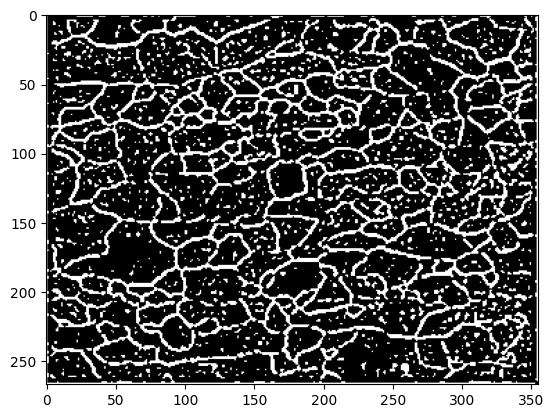

In [290]:
from skimage import exposure

# Contrast stretching
p2, p98 = np.percentile(image, (2, 98))
img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(image)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)

img_eq[img_eq>0.25] = 1
img_eq[img_eq<=0.25] = 0
img_eq = 1 - img_eq

fig, ax = plt.subplots()
plt.hist(img_eq.copy().flatten(), bins=np.arange(-1, 1, 0.01))

image_prproc = np.zeros((img_eq.shape[0], img_eq.shape[1], 3), np.uint8)
image_prproc[:,:,0] = img_eq * 255;
image_prproc[:,:,1] = img_eq * 255;
image_prproc[:,:,2] = img_eq * 255;
iio.imwrite("./data/preprocessed01.png", image_prproc)
print(image_prproc)
fig, ax = plt.subplots()
plt.imshow(image_prproc)

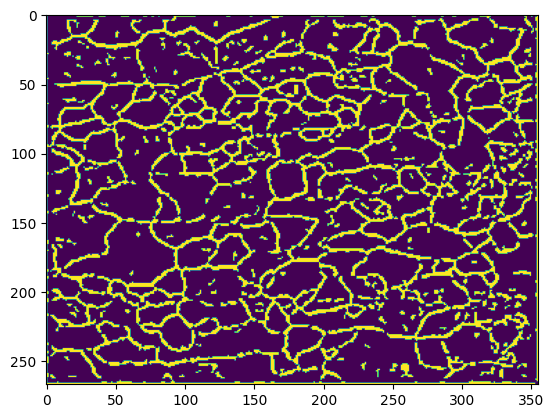

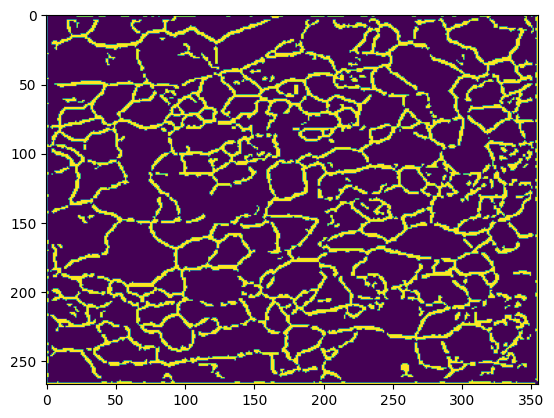

In [291]:
def remove_islands(image, kernel_size=5):
    kernel = np.zeros((kernel_size, kernel_size), np.uint8)
    kernel[:,0] = 1
    kernel[0,:] = 1
    kernel[:,-1] = 1
    kernel[-1,:] = 1
    # print(kernel)


    for i in range(0, image.shape[0]-kernel_size):
        for j in range(0, image.shape[1]-kernel_size):
            border = image[i:i+kernel_size, j:j+kernel_size]
            if((border*kernel).sum() == 0):
                image[i:i+kernel_size, j:j+kernel_size] = 0

remove_islands(img_eq)
fig, ax = plt.subplots()
plt.imshow(img_eq)
remove_islands(img_eq, 10)
fig, ax = plt.subplots()
plt.imshow(img_eq)

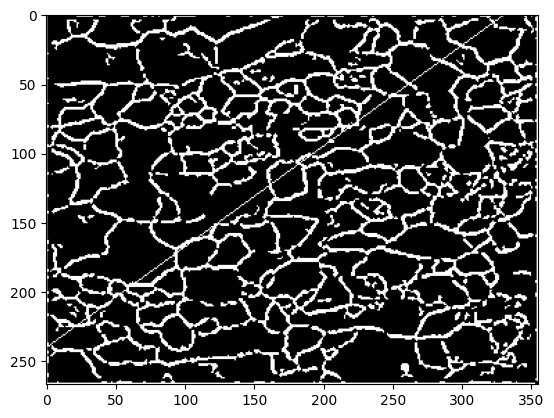

In [292]:
from skimage.draw import line

rr, cc = line(0,330,240,0)
# print(list(zip(rr,cc)))
image_copy = np.zeros(img_eq.shape, np.uint8)
image_copy = img_eq.copy()
image_copy[rr, cc] = 1
plt.imshow(image_copy, cmap='gray')

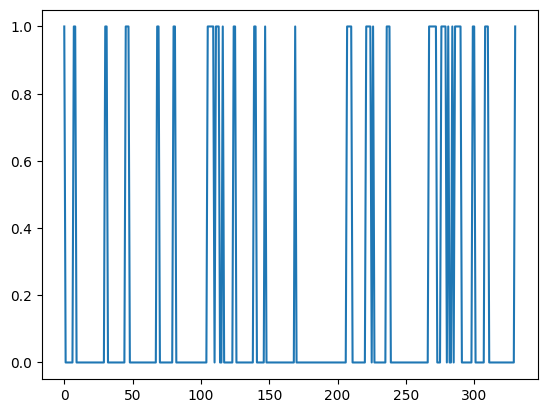

In [293]:
line_pixels=img_eq[rr, cc]
plt.plot(line_pixels)
# line_pixels

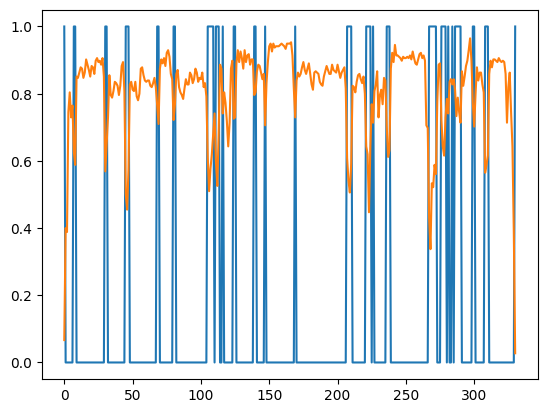

In [294]:
gray_line_pixels=gray_image[rr, cc]
plt.plot(line_pixels)
plt.plot(gray_line_pixels)
plt.show()

0.628796286415433


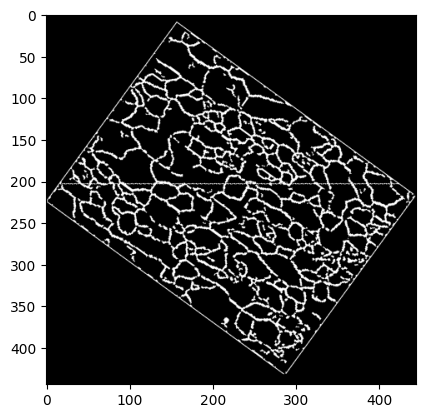

In [295]:
from skimage.transform import rotate
import math
angle = math.atan(240/330)
print(angle)
new_size = int(math.sqrt(image_copy.shape[0]*image_copy.shape[0]+image_copy.shape[1]*image_copy.shape[1]))
padded = np.zeros((new_size, new_size), np.uint8)

x_center = (new_size - image_copy.shape[1]) // 2
y_center = (new_size - image_copy.shape[0]) // 2

padded[y_center:y_center+image_copy.shape[0], 
       x_center:x_center+image_copy.shape[1]] = image_copy

rotated = rotate(padded, -angle/math.pi*180)
plt.imshow(rotated, cmap='gray')

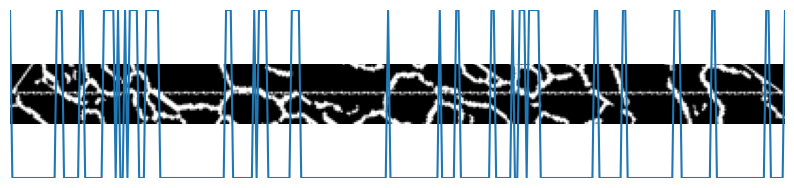

In [296]:
stripe_image = rotated[188:220, 15:425]
fig = plt.figure()
fig.set_figwidth(10)
fig.add_subplot(2, 1, 1)
plt.imshow(stripe_image, cmap='gray')
plt.axis('off')
fig.add_subplot(2, 1, 1)
plt.plot(np.flip(line_pixels))
# plt.plot(line_pixels)
plt.axis('off')
plt.autoscale(tight=True)
plt.show()

In [297]:
peaks = line_pixels.copy()
print(line_pixels.sum())
for i in range(3, len(line_pixels)-3):
    if not peaks[i] and peaks[i-1] and not peaks[i-2] and peaks[i+1] and not peaks[i+2]:
        peaks[i] = True
    else:
        if peaks[i] and not peaks[i-1] and peaks[i-2] and not peaks[i+1] and peaks[i+2]:
            peaks[i] = False
peaks = np.flip(peaks)
print(peaks.sum())
# peaks

62.0
62.0


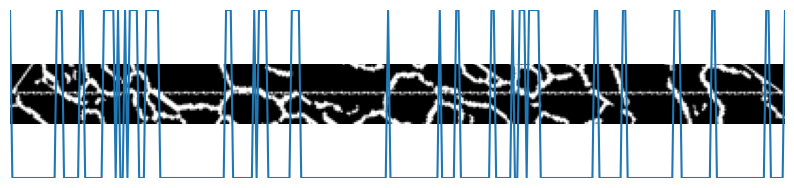

In [298]:
fig = plt.figure()
fig.set_figwidth(10)
fig.add_subplot(2, 1, 1)
plt.imshow(stripe_image, cmap='gray')
plt.axis('off')
fig.add_subplot(2, 1, 1)
plt.plot(peaks)
plt.axis('off')
plt.autoscale(tight=True)
plt.show()

(array([1., 0., 0., 2., 2., 1., 1., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
        1., 0., 1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]),
 array([ 3.        ,  3.89473684,  4.78947368,  5.68421053,  6.57894737,
         7.47368421,  8.36842105,  9.26315789, 10.15789474, 11.05263158,
        11.94736842, 12.84210526, 13.73684211, 14.63157895, 15.52631579,
        16.42105263, 17.31578947, 18.21052632, 19.10526316, 20.        ,
        20.89473684, 21.78947368, 22.68421053, 23.57894737, 24.47368421,
        25.36842105, 26.26315789, 27.15789474, 28.05263158, 28.94736842,
        29.84210526, 30.73684211, 31.63157895, 32.52631579, 33.42105263,
        34.31578947, 35.21052632, 36.10526316, 37.        ]),
 <BarContainer object of 38 artists>)

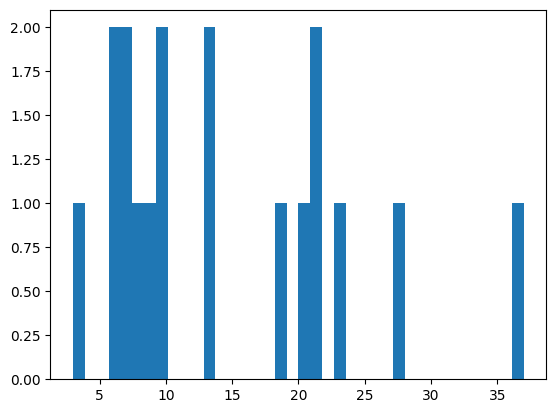

In [299]:
grains = []
curr_len = 0
for i in range(len(peaks)):
    if peaks[i]:
        if curr_len > 0:
            grains.append(curr_len)
        curr_len = 0
    else:
        curr_len += 1
grains = np.array(grains)
plt.hist(grains[grains>2], density=False, bins=max(grains)+1)
